# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


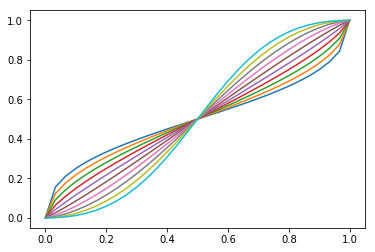

In [5]:
p = np.linspace(0, 1, 31)
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))
    
#plt.plot(p, sigmoid(4.*logit(p)))
for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [7]:
def regress(ax, p, data, t_label=10, color='k', lw=2, axis=None) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    
    ax.plot(x_test, fitLine, c=color, linewidth=lw)

    if axis is None :
        x1, x2 = np.min(p), np.max(p)
        y1, y2 = np.min(data), np.max(data)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10
    ax.text(x2, y_pos_r, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    
    return ax


In [8]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def r_weight(ax, x, y, w, t_label=10, color='k', lw=2, axis=None) :
    
    x = np.ma.masked_array(x, mask=np.isnan(y)).compressed()
    y = np.ma.masked_array(y, mask=np.isnan(y)).compressed()
    
    # Weighted Mean
    def m(x, w): return np.sum(x * w) / np.sum(w)
    # Weighted Covariance
    def cov(x, y, w): return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
    # Weighted Correlation
    def corr(x, y, w): return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))    

    r = corr(x, y, w)
    
    if axis is None : x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
    else :            x1, x2, y1, y2 = axis[0],   axis[1],   axis[2],   axis[3]
    
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    ax.text(x1, y_pos_r, 'r weight = %0.3f'%(r), color=color, fontsize=t_label/1.2, ha='left')
    
    return ax


In [9]:
Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
tau = np.arange(1, 601, 1)
list_h = 1/tau
#print(h)

for num, s in enumerate(['TN']):#set(Full.sujet)[0]) :
    print(s)#, end=' ')
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_k, h_k = [], []
    for k in range(11) : r_k.append([]) ; h_k.append([])
    
    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_logit, r_bet_ = [], []
        for c in range(0, 3*200-150, 200) : r_bet_logit.append([]) ; r_bet_.append([])
        
        for h in list_h :

            for d, c in enumerate(range(0, 3*200-150, 200)) :
                x_100 = x[c:c+200]
                p_hat_100 = np.zeros(200)

                liste = [0, 50, 100, 150, 200]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    p_hat_100[liste[a]:liste[a+1]] = p_hat_p

                if num==0 : r_bet_[d].append(r_(p_hat_100.tolist(), bet[c:c+200]))
                r_bet_logit[d].append(r_(sigmoid(k*logit(p_hat_100)), bet[c:c+200]))

        h_bet_logit, h_bet_ = [], []
        r_bet_l, r_bet = [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :

            if num==0 : h_bet_.append(list_h[np.argmax(r_bet_[d])])
            h_bet_logit.append(list_h[np.argmax(r_bet_logit[d])])

            if num==0 : r_bet.append(np.max(r_bet_[d]))
            r_bet_l.append(np.max(r_bet_logit[d]))
            

        if num==0 : print('\nBet :\nh=', h_bet_, '\nr=', r_bet, end='\n\n\n')
        print('\nBet Logit :', num, '-', k, '\nh=', h_bet_logit, '\nr=', r_bet_l, end='\n\n\n')
        
        if num==0 : h_k[0]=h_bet_; r_k[0]=r_bet
        h_k[num+1]=h_bet_logit ; r_k[num+1]=r_bet_l

TN


/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)



Bet :
h= [0.015384615384615385, 0.043478260869565216, 0.03333333333333333] 
r= [0.7568801270144442, 0.8811399593417123, 0.8699665413860169]



Bet Logit : 0 - 0.5 
h= [0.015384615384615385, 0.08333333333333333, 0.034482758620689655] 
r= [0.7653656262118976, 0.8716189209830969, 0.8585973130724125]



Bet Logit : 1 - 0.5832645197880583 
h= [0.014705882352941176, 0.07142857142857142, 0.034482758620689655] 
r= [0.7651374838432826, 0.8728815018760431, 0.860523859577746]



Bet Logit : 2 - 0.6803950000871885 
h= [0.014492753623188406, 0.06666666666666667, 0.034482758620689655] 
r= [0.7642549183968177, 0.8745975600248184, 0.8628420209611957]



Bet Logit : 3 - 0.7937005259840997 
h= [0.014705882352941176, 0.05555555555555555, 0.03333333333333333] 
r= [0.7623601779838148, 0.8768609275105893, 0.8655230897376991]



Bet Logit : 4 - 0.9258747122872903 
h= [0.015151515151515152, 0.047619047619047616, 0.03333333333333333] 
r= [0.7591030459380398, 0.8796294881821184, 0.8684624834233067]



Bet Logi

Plot de R en fonction de la pente

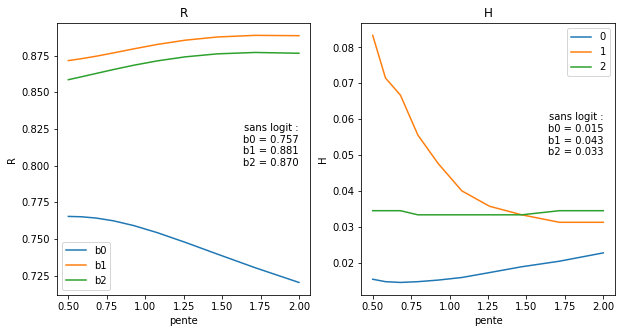

In [10]:
fig, ax = plt.subplots(1,2,figsize=(2*5,5))

ax[0].text(2, 0.8, 'sans logit :\nb0 = %0.3f\nb1 = %0.3f\nb2 = %0.3f'%(np.array(r_k)[0,0],
                                                                       np.array(r_k)[0,1],
                                                                       np.array(r_k)[0,2]), ha='right')

ax[1].text(2, 0.05, 'sans logit :\nb0 = %0.3f\nb1 = %0.3f\nb2 = %0.3f'%(np.array(h_k)[0,0],
                                                                       np.array(h_k)[0,1],
                                                                       np.array(h_k)[0,2]), ha='right')
#ax[1].plot(np.arange(len(h_k[0])), h_k[0], alpha=0.4, label='sans logit')

for block in range(3) :
    ax[0].plot(np.logspace(-1, 1, 10, base=2), np.array(r_k)[1:,block], label='b%s'%block)
    ax[1].plot(np.logspace(-1, 1, 10, base=2), np.array(h_k)[1:,block], label=block)
    

ax[0].set_title('R') ; ax[1].set_title('H')
ax[0].set_ylabel('R') ; ax[1].set_ylabel('H')
for a in range(2) :
    ax[a].legend()
    ax[a].set_xlabel('pente')
    

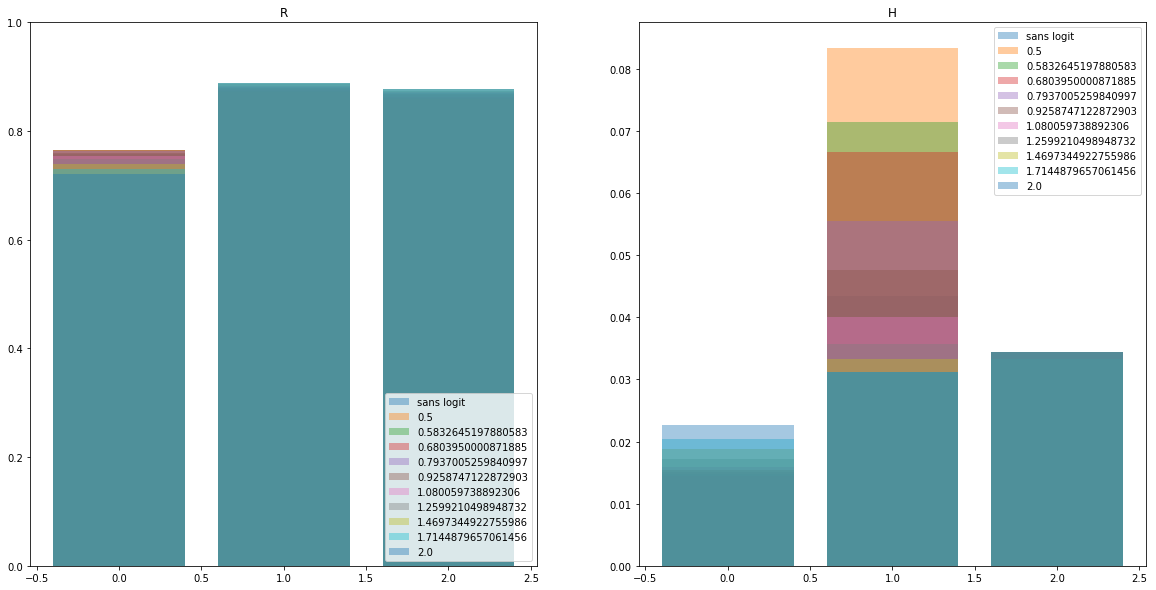

In [13]:
fig, ax = plt.subplots(1,2,figsize=(2*10,10))

ax[0].bar(np.arange(len(r_k[0])), r_k[0], alpha=0.4, label='sans logit')
ax[1].bar(np.arange(len(h_k[0])), h_k[0], alpha=0.4, label='sans logit')

for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
    ax[0].bar(np.arange(len(r_k[num+1])), r_k[num+1], alpha=0.4, label=k)
    ax[1].bar(np.arange(len(h_k[num+1])), h_k[num+1], alpha=0.4, label=k)
    
ax[0].legend(loc=4) ; ax[1].legend()
ax[0].set_ylim(0,1)
ax[0].set_title('R') ; ax[1].set_title('H') ;